In [1]:
#install and download needed packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import scipy
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor,BaggingRegressor,GradientBoostingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict,KFold
from sklearn.metrics import mean_squared_error,accuracy_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.decomposition import PCA
import statsmodels.api as sm
warnings.filterwarnings('ignore')

In [2]:
data= pd.read_csv('TSLA.csv')

In [3]:
data.shape 

(3307, 7)

In [4]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-12-06,2.090000,2.096667,1.970667,2.020667,2.020667,19116000
1,2010-12-07,2.032667,2.160000,2.003333,2.104000,2.104000,19669500
2,2010-12-08,2.165333,2.166000,2.101333,2.158000,2.158000,9900000
3,2010-12-09,2.167333,2.181333,2.110000,2.136667,2.136667,6090000
4,2010-12-10,2.136667,2.194667,2.075333,2.101333,2.101333,6441000


In [5]:
data.index 

RangeIndex(start=0, stop=3307, step=1)

In [6]:
data=data.rename(columns={'Date':'date','Open':'open','High':'high','Low':'low','Close':'close','Volume':'volume'})

In [7]:
data=data.drop(columns=['Adj Close'],axis=1)

In [8]:
data['date']=pd.to_datetime(data['date'])

In [9]:
data.set_index('date', inplace=True)

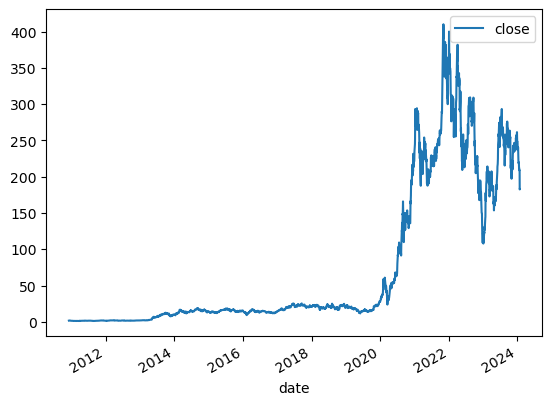

In [10]:
data.plot.line(y='close', use_index=True)
plt.savefig('TSLA.png');

In [11]:
data.describe()

,open,high,low,close,volume
count,3307.000000,3307.000000,3307.000000,3307.000000,3.307000e+03
mean,73.635786,75.247165,71.891924,73.606572,9.935616e+07
std,102.769132,105.044743,100.253200,102.677946,7.968570e+07
min,1.452000,1.484667,1.407333,1.455333,3.594000e+06
25%,12.389000,12.706667,12.167666,12.444333,4.982535e+07
50%,17.379999,17.632000,17.049999,17.382668,8.390700e+07
75%,136.614998,140.014999,134.483338,136.864998,1.251366e+08
max,411.470001,414.496674,405.666656,409.970001,9.140820e+08


In [11]:
data['Tomorrow']=data['close'].shift(-1)

In [12]:
data['previousday']=data['close'].shift(1)

In [13]:
data.head() 

,open,high,low,close,volume,Tomorrow,previousday
date,,,,,,,
2010-12-06,2.090000,2.096667,1.970667,2.020667,19116000,2.104000,NaN
2010-12-07,2.032667,2.160000,2.003333,2.104000,19669500,2.158000,2.020667
2010-12-08,2.165333,2.166000,2.101333,2.158000,9900000,2.136667,2.104000
2010-12-09,2.167333,2.181333,2.110000,2.136667,6090000,2.101333,2.158000
2010-12-10,2.136667,2.194667,2.075333,2.101333,6441000,2.036667,2.136667


In [14]:
data.head()

,open,high,low,close,volume,Tomorrow,previousday
date,,,,,,,
2010-12-06,2.090000,2.096667,1.970667,2.020667,19116000,2.104000,NaN
2010-12-07,2.032667,2.160000,2.003333,2.104000,19669500,2.158000,2.020667
2010-12-08,2.165333,2.166000,2.101333,2.158000,9900000,2.136667,2.104000
2010-12-09,2.167333,2.181333,2.110000,2.136667,6090000,2.101333,2.158000
2010-12-10,2.136667,2.194667,2.075333,2.101333,6441000,2.036667,2.136667


In [15]:
train = data.iloc[:-200]
test = data.iloc[-200:]

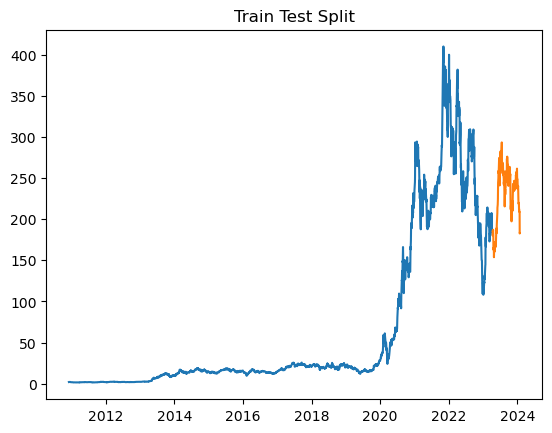

In [16]:
import matplotlib.pyplot as plt 
plt.plot(train['close'], label='train')
plt.plot(test['close'], label='test')
plt.title('Train Test Split');

In [17]:
# Utility function
def evaluate_model(model, x, y):
    """
    Utility function to print the model performance, (MAE and MAPE)
    model: Fitted model
    x:  features dataset
    y:  target values
    """
    predicted = model.predict(x) #get predictions
    mae = mean_absolute_error(y_true=y, y_pred=predicted)
    abs_errors= np.abs(np.array(predicted) - np.array(y))
    min_abs_errors= np.min(abs_errors)
    max_abs_errors= np.max(abs_errors)
    med_abs_errors= np.median(abs_errors)
    mape = mean_absolute_percentage_error(y, predicted)

    print('MAE: {:.2f}'.format(mae))
    print('MAPE: {:.2f}'.format(mape))
    print('minae: {:.2f}'.format(min_abs_errors))
    print('maxae: {:.2f}'.format(max_abs_errors))
    print('medae: {:.2f}'.format(med_abs_errors))
    print()

In [18]:
#predictors_1 = ["close", "volume", "open", "high", "low"]
predictors_2 = ["volume", "open", "high", "low"]

In [19]:
# creating a dictionary of Regressors to be experimented on.
models_dict = {
          'RF Regressor':RandomForestRegressor(random_state=0),
          'xgboost': XGBRegressor(),'Gradient Boost': GradientBoostingRegressor(random_state=0),
    'Catboostregressor':CatBoostRegressor(iterations=100, early_stopping_rounds=50)
         }

#looping through all the regressors, fitting and evaluating them on  test data respectively
for key, model in models_dict.items():
    model.fit(train[predictors_2], train['close'])
    print(f'Performance of "{key}" on Validation and Test set:')
    print('=='*28)
    print ( 'Test set:')
    print("**"*8)
    evaluate_model(model,test[predictors_2], test['close'])





Performance of "RF Regressor" on Validation and Test set:
Test set:
****************
MAE: 2.60
MAPE: 0.01
minae: 0.05
maxae: 8.72
medae: 2.30

Performance of "xgboost" on Validation and Test set:
Test set:
****************
MAE: 3.09
MAPE: 0.01
minae: 0.01
maxae: 10.31
medae: 2.60

Performance of "Gradient Boost" on Validation and Test set:
Test set:
****************
MAE: 2.96
MAPE: 0.01
minae: 0.00
maxae: 10.96
medae: 2.43

Learning rate set to 0.318397
0:	learn: 67.4888570	total: 144ms	remaining: 14.2s
1:	learn: 47.3956144	total: 146ms	remaining: 7.15s
2:	learn: 33.2028933	total: 148ms	remaining: 4.78s
3:	learn: 23.6814935	total: 150ms	remaining: 3.6s
4:	learn: 17.0405293	total: 154ms	remaining: 2.92s
5:	learn: 12.5992864	total: 157ms	remaining: 2.45s
6:	learn: 9.5599332	total: 160ms	remaining: 2.12s
7:	learn: 7.6417048	total: 162ms	remaining: 1.87s
8:	learn: 6.3882198	total: 165ms	remaining: 1.66s
9:	learn: 5.6498924	total: 167ms	remaining: 1.5s
10:	learn: 5.1682062	total: 170ms	rema

#### Retrain the best Model(Extreme Gradient Boosting)

In [20]:
model= GradientBoostingRegressor()
model.fit(train[predictors_2], train['close'])
pred= model.predict(test[predictors_2])

In [21]:

pred= pd.Series(pred, index=test.index)
combined_2= pd.concat([test['close'], pred],axis=1)

In [22]:
#combined_1.plot();
combined_2

,close,0
date,,
2023-04-12,180.539993,190.979242
2023-04-13,185.899994,184.314907
2023-04-14,185.000000,184.314907
2023-04-17,187.039993,184.314907
2023-04-18,184.309998,184.314907
...,...,...
2024-01-22,208.800003,213.771787
2024-01-23,209.139999,214.343808
2024-01-24,207.830002,214.343808


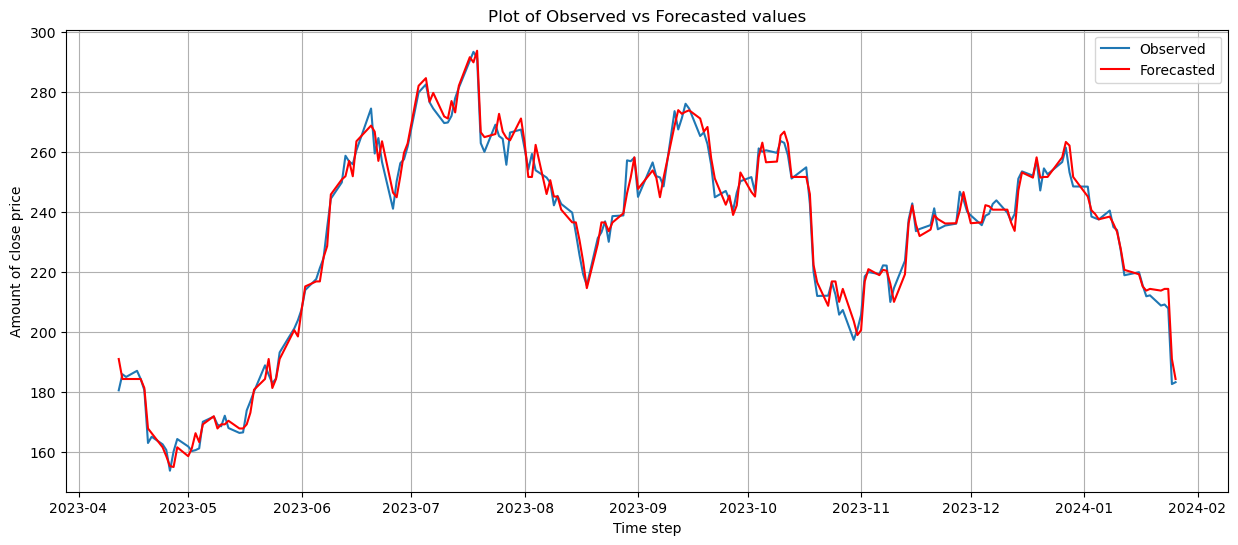

In [23]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(combined_2['close'], label='Observed')
plt.plot(combined_2[0], color='r', label='Forecasted')
plt.title('Plot of Observed vs Forecasted values')
plt.ylabel('Amount of close price')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

In [24]:
#add additional predictors to the model
#calculate the mean close price in certain days and  find the ratio between today's closing price and that of the periods
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = data.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    data[ratio_column] = data["close"] / rolling_averages["close"]
    
    trend_column = f"Trend_{horizon}"
    data[trend_column] = data.shift(1).rolling(horizon).sum()["close"]
    
    
    
    new_predictors+= [ratio_column, trend_column]

In [25]:
data['mom'] = data['close'].pct_change(12) # 12 month change

In [26]:
#Create the RSI indicator
#data['rsi' + str(n)] = talib.RSI(data['close'].values, timeperiod=horizon)
def computeRSI (data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    
    # we set com=time_window-1 so we get decay alpha=1/time_window
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

In [27]:
data['RSI']= computeRSI(data['close'], 14)

In [28]:
data.head()

,open,high,low,close,volume,Tomorrow,previousday,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000,mom,RSI
date,,,,,,,,,,,,,,,,,,,
2010-12-06,2.090000,2.096667,1.970667,2.020667,19116000,2.104000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-07,2.032667,2.160000,2.003333,2.104000,19669500,2.158000,2.020667,1.020204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-08,2.165333,2.166000,2.101333,2.158000,9900000,2.136667,2.104000,1.012670,4.124667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-09,2.167333,2.181333,2.110000,2.136667,6090000,2.101333,2.158000,0.995033,4.262000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-10,2.136667,2.194667,2.075333,2.101333,6441000,2.036667,2.136667,0.991663,4.294667,0.998669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
data.shape 

(3307, 19)

In [30]:
new_data=data[new_predictors]
new_data['close']=data['close']
new_data['MOM']=data['mom']
new_data.head()

,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000,close,MOM
date,,,,,,,,,,,,
2010-12-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.020667,NaN
2010-12-07,1.020204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.104000,NaN
2010-12-08,1.012670,4.124667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.158000,NaN
2010-12-09,0.995033,4.262000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.136667,NaN
2010-12-10,0.991663,4.294667,0.998669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.101333,NaN


In [31]:
new_data['SMA_3'] = new_data.iloc[:,10].rolling(window=3).mean()
new_data['SMA_4'] = new_data.iloc[:,10].rolling(window=4).mean()

In [32]:
new_data['CMA_4'] = new_data['close'].expanding(min_periods=4).mean()

In [33]:
new_data['EMA'] = new_data.iloc[:,10].ewm(span=40,adjust=False).mean()

In [34]:
new_data=new_data.dropna()
new_data.shape 

(2307, 16)

In [35]:
new_data.head()

,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000,close,MOM,SMA_3,SMA_4,CMA_4,EMA
date,,,,,,,,,,,,,,,,
2014-11-25,1.002769,32.633333,1.005194,82.910001,0.993890,1000.862670,1.145516,3601.503997,2.685848,6143.436657,16.539333,0.032848,16.390889,16.438333,6.153822,16.373393
2014-11-26,1.000705,32.987333,1.006042,82.269334,0.997473,998.460669,1.144571,3609.580663,2.683337,6157.955323,16.562668,0.026909,16.516667,16.433833,6.164210,16.382626
2014-11-28,0.992048,33.102001,0.993539,82.316001,0.984470,996.277337,1.124019,3617.657998,2.634960,6172.413991,16.301332,-0.026127,16.467778,16.462833,6.174317,16.378661
2014-12-01,0.972950,32.864000,0.949804,82.036666,0.935485,993.509337,1.063112,3625.681330,2.490808,6186.557323,15.442667,-0.070092,16.102222,16.211500,6.183548,16.333002
2014-12-02,0.999547,31.743999,0.960992,81.294000,0.937836,990.459338,1.060348,3631.477330,2.483212,6199.863323,15.428667,-0.080532,15.724222,15.933833,6.192748,16.288888


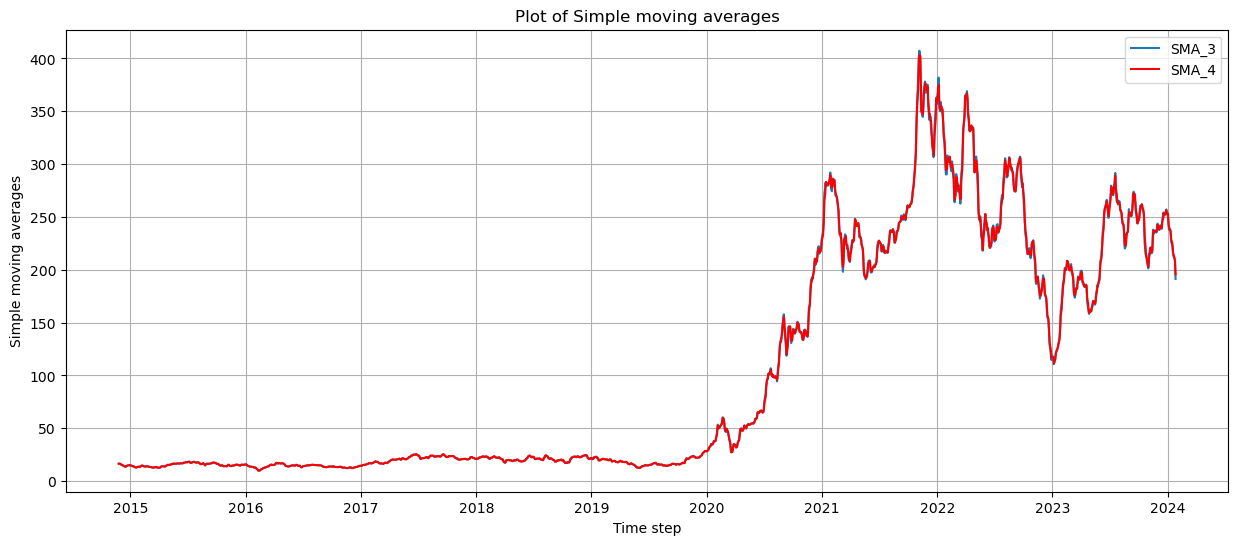

In [36]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(new_data['SMA_3'], label='SMA_3')
plt.plot(new_data['SMA_4'], color='r', label='SMA_4')
plt.title('Plot of Simple moving averages')
plt.ylabel('Simple moving averages')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

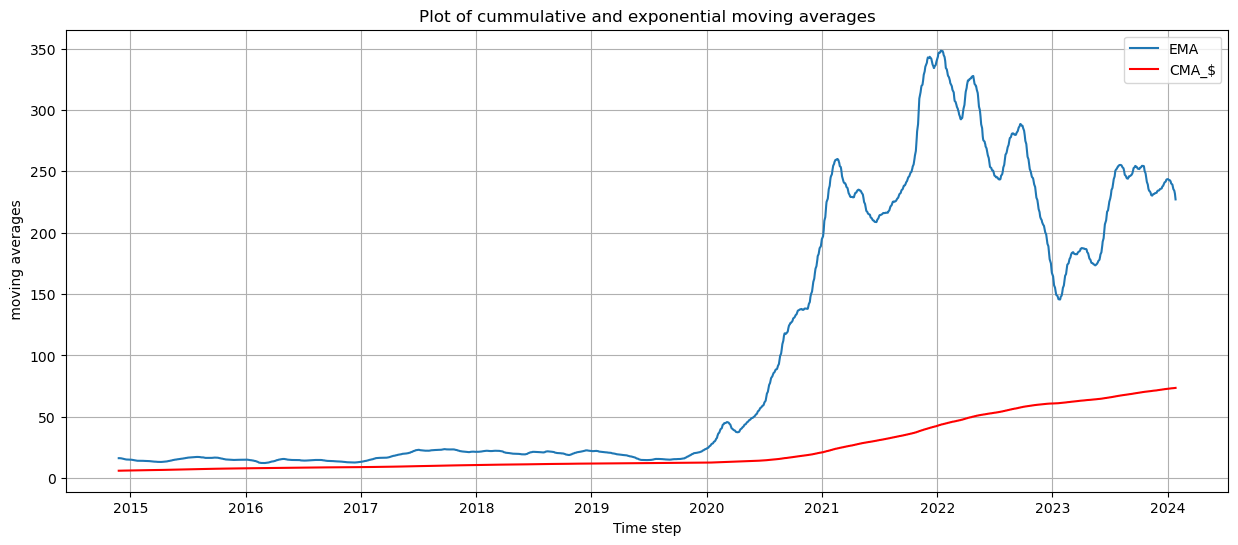

In [37]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(new_data['EMA'], label='EMA')
plt.plot(new_data['CMA_4'], color='r', label='CMA_$')
plt.title('Plot of cummulative and exponential moving averages')
plt.ylabel(' moving averages')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

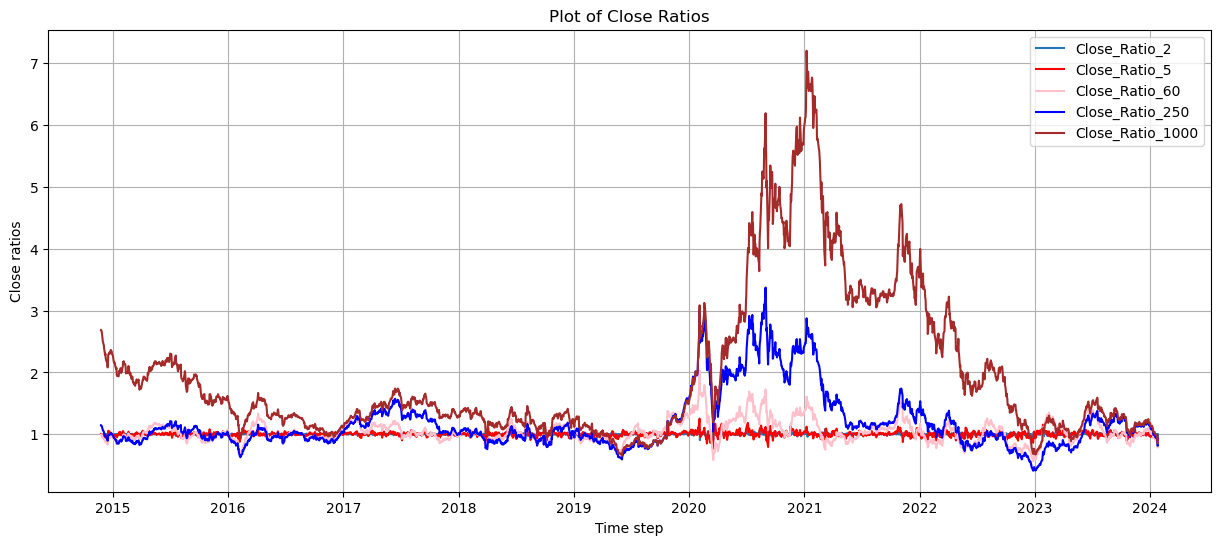

In [38]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(new_data['Close_Ratio_2'], label='Close_Ratio_2')
plt.plot(new_data['Close_Ratio_5'], color='r', label='Close_Ratio_5')
plt.plot(new_data['Close_Ratio_60'], color='pink', label='Close_Ratio_60')
plt.plot(new_data['Close_Ratio_250'], color='b', label='Close_Ratio_250')
plt.plot(new_data['Close_Ratio_1000'], color='brown', label='Close_Ratio_1000')
#plt.plot(new_data['close'], color='g', label='Close_Ratio_2')
plt.title('Plot of Close Ratios')
plt.ylabel('Close ratios')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

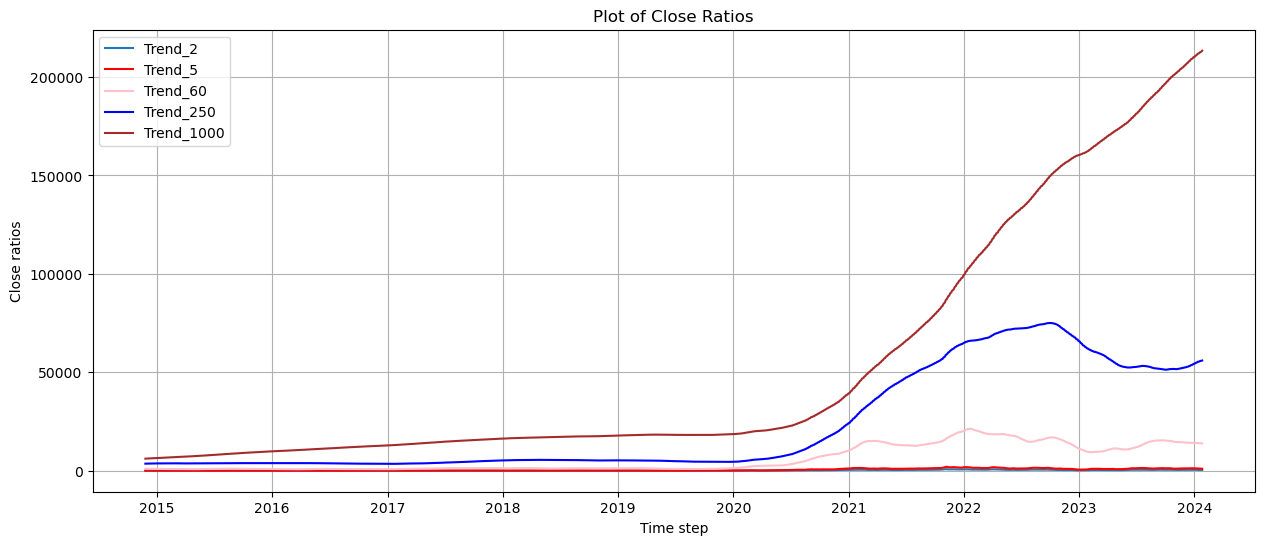

In [39]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(new_data['Trend_2'], label='Trend_2')
plt.plot(new_data['Trend_5'], color='r', label='Trend_5')
plt.plot(new_data['Trend_60'], color='pink', label='Trend_60')
plt.plot(new_data['Trend_250'], color='b', label='Trend_250')
plt.plot(new_data['Trend_1000'], color='brown', label='Trend_1000')
#plt.plot(new_data['close'], color='g', label='Close_Ratio_2')
plt.title('Plot of Close Ratios')
plt.ylabel('Close ratios')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

In [40]:
new_data['RSI']=data['RSI']

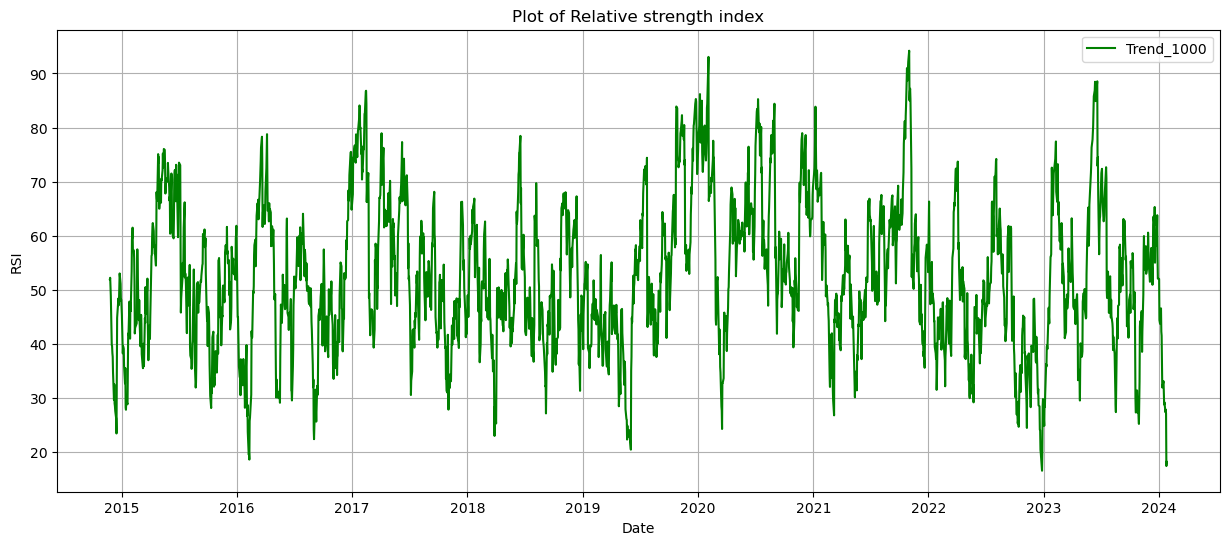

In [41]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(new_data['RSI'], color='g', label='Trend_1000')
#plt.plot(new_data['close'], color='g', label='Close_Ratio_2')
plt.title('Plot of Relative strength index')
plt.ylabel('RSI')
plt.xlabel('Date')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

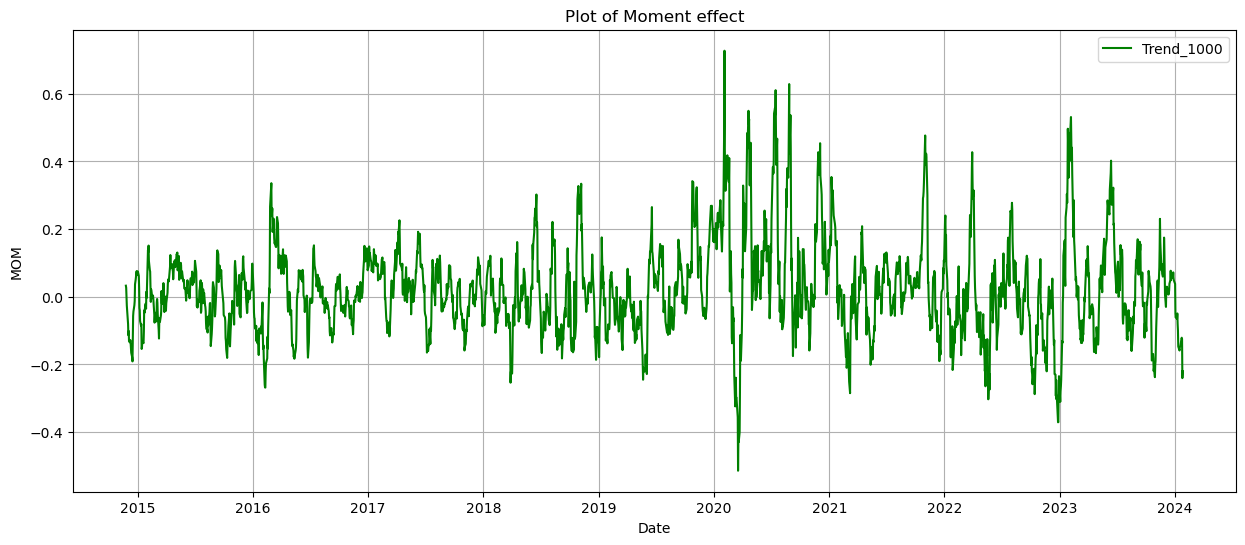

In [42]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(new_data['MOM'], color='g', label='Trend_1000')
#plt.plot(new_data['close'], color='g', label='Close_Ratio_2')
plt.title('Plot of Moment effect')
plt.ylabel('MOM')
plt.xlabel('Date')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

In [43]:
new_data['previousday']=data['previousday']

In [44]:
train = new_data.iloc[:-200]
test = new_data.iloc[-200:]

In [45]:
train.shape

(2107, 18)

In [46]:
new_data.columns

Index(['Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5',
       'Close_Ratio_60', 'Trend_60', 'Close_Ratio_250', 'Trend_250',
       'Close_Ratio_1000', 'Trend_1000', 'close', 'MOM', 'SMA_3', 'SMA_4',
       'CMA_4', 'EMA', 'RSI', 'previousday'],
      dtype='object')

In [47]:
predictors= ['SMA_3','SMA_4','EMA','RSI','MOM','previousday'] 

#### Retrain the models on the new predictors

In [48]:
# creating a dictionary of Regressors to be experimented on.
models_dict = {
          'RF Regressor':RandomForestRegressor(random_state=0),
          'xgboost': XGBRegressor(),'Gradient Boost': GradientBoostingRegressor(random_state=0),
    'Catboostregressor':CatBoostRegressor(iterations=100, early_stopping_rounds=50)
         }

#looping through all the regressors, fitting and evaluating them on Cross validation and test data respectively
for key, model in models_dict.items():
    model.fit(train[predictors], train['close'])
    print(f'Performance of "{key}" on  Test set:')
    print('=='*28)
    print ( 'Test set:')
    print("**"*8)
    evaluate_model(model,test[predictors], test['close'])

Performance of "RF Regressor" on  Test set:
Test set:
****************
MAE: 4.08
MAPE: 0.02
minae: 0.03
maxae: 15.50
medae: 3.16

Performance of "xgboost" on  Test set:
Test set:
****************
MAE: 4.47
MAPE: 0.02
minae: 0.03
maxae: 19.57
medae: 3.60

Performance of "Gradient Boost" on  Test set:
Test set:
****************
MAE: 4.09
MAPE: 0.02
minae: 0.05
maxae: 19.18
medae: 3.52

Learning rate set to 0.299446
0:	learn: 77.6086994	total: 3.28ms	remaining: 325ms
1:	learn: 56.5687096	total: 5.98ms	remaining: 293ms
2:	learn: 41.0867954	total: 8.59ms	remaining: 278ms
3:	learn: 30.0309265	total: 10.9ms	remaining: 261ms
4:	learn: 22.0591605	total: 13.3ms	remaining: 252ms
5:	learn: 16.5832453	total: 15.5ms	remaining: 243ms
6:	learn: 12.8684533	total: 18.2ms	remaining: 241ms
7:	learn: 10.3572800	total: 20.5ms	remaining: 235ms
8:	learn: 8.7382410	total: 23.1ms	remaining: 234ms
9:	learn: 7.7061250	total: 25.7ms	remaining: 231ms
10:	learn: 7.0617042	total: 27.9ms	remaining: 226ms
11:	learn: 6.

#### Improving the model

In [49]:
#model_1 = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)
#n_estimators=200, min_samples_split=50, random_state=1
model_2= GradientBoostingRegressor(random_state=0)

def predict(train, test, predictors_1, model_1):
    model_1.fit(train[predictors_1], train["Target"])
    preds_1 = model_1.predict_proba(test[predictors_1])[:,1]
    preds_1[preds_1 >=.6] = 1
    preds_1[preds_1 <.6] = 0
    preds_1 = pd.Series(preds_1, index=test.index, name="Predictions_1")
    combined_1 = pd.concat([test["Target"], preds_1], axis=1)
    return combined_1 

In [50]:
def predict(train, test, predictors, model_2):
    model_2.fit(train[predictors], train["close"])
    preds_2 = model_2.predict(test[predictors])
    preds_2 = pd.Series(preds_2, index=test.index, name="Predictions_2")
    combined_2 = pd.concat([test["close"], preds_2], axis=1)
    return combined_2

In [51]:
def backtest(new_data, model_2, predictors, start=1500, step=250):
    all_predictions = []

    for i in range(start, new_data.shape[0], step):
        train = new_data.iloc[0:i].copy()
        test = new_data.iloc[i:(i+step)].copy()
        predictions_2 = predict(train, test, predictors, model_2)
        all_predictions.append(predictions_2)
    
    return pd.concat(all_predictions)

In [52]:
predictions_2 = backtest(new_data, model_2, predictors)

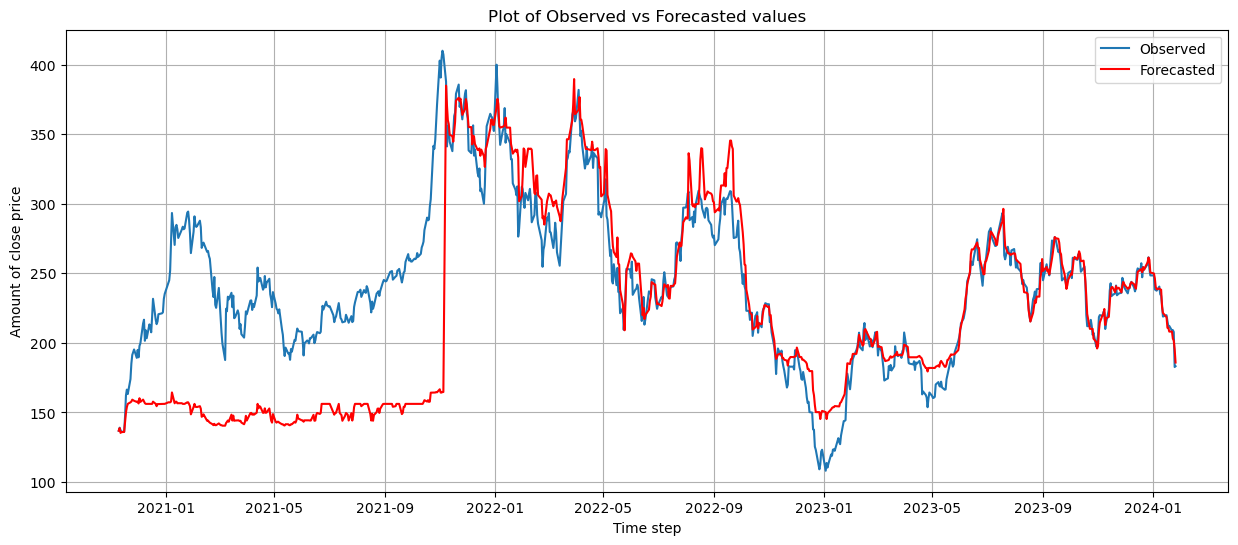

In [53]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(predictions_2['close'], label='Observed')
plt.plot(predictions_2['Predictions_2'], color='r', label='Forecasted')
plt.title('Plot of Observed vs Forecasted values')
plt.ylabel('Amount of close price')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

In [54]:
model_2.fit(train[predictors], train['close'])
prediction=model_2.predict(test[predictors])

In [55]:
mape= mean_absolute_percentage_error(test['close'], prediction)
mae=mean_absolute_error(test['close'], prediction)

In [56]:
print('mean absolute percentage error is : {}\n'.format(mape))
print('mean absolute  error is : {}\n'.format(mae))

mean absolute percentage error is : 0.018081890026364268

mean absolute  error is : 4.08796795120036



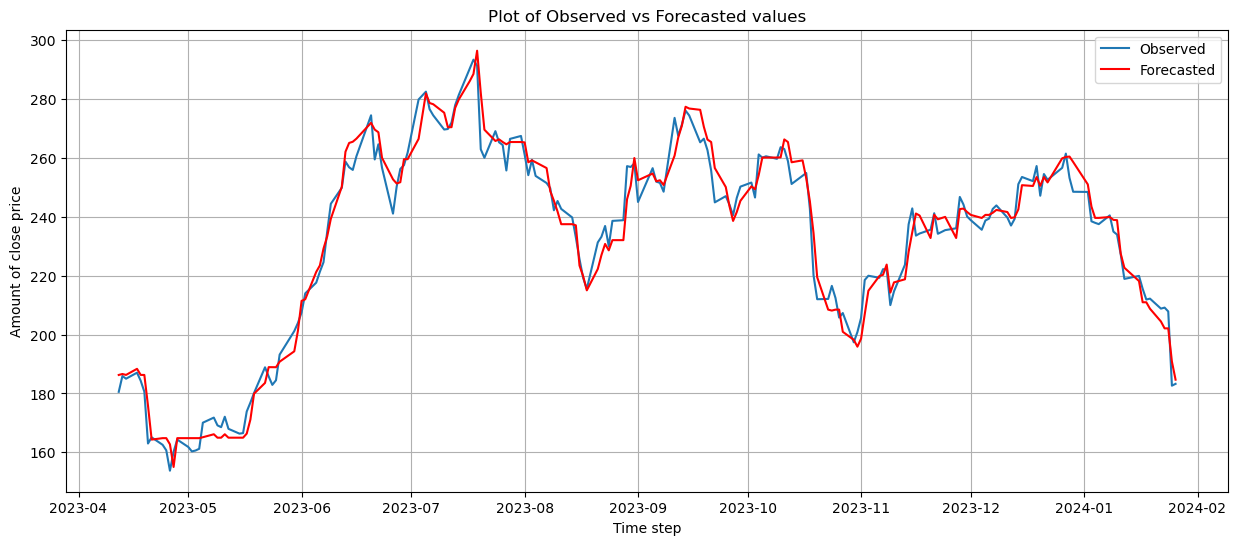

In [57]:
# Plot the test predictions and true values
pred= pd.Series(prediction, index=test.index)
plt.figure(figsize=(15,6))
plt.plot(test['close'], label='Observed')
plt.plot(pred, color='r', label='Forecasted')
plt.title('Plot of Observed vs Forecasted values')
plt.ylabel('Amount of close price')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

#### Perform Hyper parameter tuning using grid searchcv

#possibe hyperparameters for random forest
hyper = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 6]
}

from sklearn.model_selection import GridSearchCV

cv_model= GridSearchCV(GradientBoostingRegressor(), param_grid=hyper)
cv_model.fit(train[predictors], train['close'])

print(cv_model.best_score_)
print(cv_model.best_estimator_)

In [58]:
model = GradientBoostingRegressor(max_depth=5, n_estimators=100, learning_rate=0.1, min_samples_split=5)
model.fit(train[predictors], train['close'])
prediction=model.predict(test[predictors])

In [59]:
grdb_mae =  mean_absolute_error(test['close'], prediction)
abs_errors= np.abs(np.array(prediction) - np.array(test['close']))
grdb_min_abs_errors= np.min(abs_errors)
grdb_max_abs_errors= np.max(abs_errors)
grdb_med_abs_errors= np.median(abs_errors)
grdb_mape = mean_absolute_percentage_error(test['close'], prediction)

In [60]:
print(f"Optimized Gradient boosting Performance Metrics \n\n \
gradientboost Mae: {grdb_mae} \n \
gradientboost minae: {grdb_min_abs_errors} \n \
gradientboost maxae: {grdb_max_abs_errors} \n \
gradientboost medae: {grdb_med_abs_errors} \n \
gradientboost Mape: {grdb_mape} \n \
 \n\n <-------------------------------------------------->\n")

Optimized Gradient boosting Performance Metrics 

 gradientboost Mae: 3.93382206463648 
 gradientboost minae: 0.002750479407069406 
 gradientboost maxae: 16.95340077145528 
 gradientboost medae: 3.154159392489248 
 gradientboost Mape: 0.01713514270977448 
  

 <-------------------------------------------------->



In [61]:
pred= pd.Series(prediction, index=test.index)
combined= pd.concat([test['close'], pred],axis=1)
combined 

,close,0
date,,
2023-04-12,180.539993,184.054604
2023-04-13,185.899994,186.238683
2023-04-14,185.000000,184.038198
2023-04-17,187.039993,189.048978
2023-04-18,184.309998,183.764976
...,...,...
2024-01-22,208.800003,205.357961
2024-01-23,209.139999,201.256893
2024-01-24,207.830002,201.256893


In [62]:
mape= mean_absolute_percentage_error(test['close'], prediction)
mae=mean_absolute_error(test['close'], prediction)

In [63]:
print('mean absolute percentage error is : {}\n'.format(mape))
print('mean absolute  error is : {}\n'.format(mae))

mean absolute percentage error is : 0.01713514270977448

mean absolute  error is : 3.93382206463648



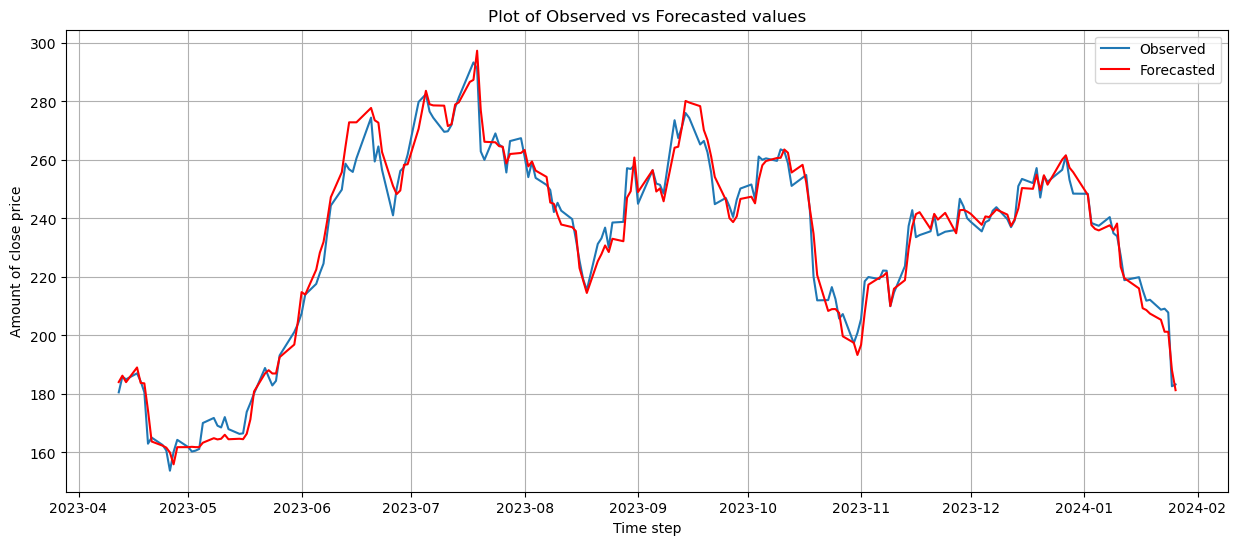

In [64]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(combined['close'], label='Observed')
plt.plot(combined[0], color='r', label='Forecasted')
plt.title('Plot of Observed vs Forecasted values')
plt.ylabel('Amount of close price')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

### Stacking and Bagging

In [65]:
# List of machine learning algorithms to consider
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso,ElasticNet 
algorithms = [
    ('Linear regression', LinearRegression(), {}),
    ('Ridge', Ridge(), {}),
    ('Lasso', Lasso(), {}),
    ('Elastic Net', ElasticNet(), {}),
    #('SVM', SVC(kernel='linear', probability=True, decision_function_shape='ovr'), {}),
    ('MLP', MLPRegressor(), {})
]

# Train base models
base_models = {}
for algorithm_name, algorithm, _ in algorithms:
    print(algorithm)
    model = algorithm
    model.fit(train[predictors], train['close'])
    base_models[algorithm_name] = model

eval_metrics = ['mae', 'mape']
results = pd.DataFrame(columns=['Algorithm'] + eval_metrics)

for algorithm_name, model in base_models.items():
    y_pred = model.predict(test[predictors])
    mae= mean_absolute_error(test['close'], y_pred)
    mape =mean_absolute_percentage_error(test['close'], y_pred)

# Ensembling using Bagging with all base models
bagging_model = BaggingRegressor(base_estimator=None, n_estimators=10, random_state=42)
bagging_model.fit(train[predictors], train['close'])
bagging_y_pred = bagging_model.predict(test[predictors])
bagging_mae = mean_absolute_error(test['close'], bagging_y_pred)
abs_errors= np.abs(np.array(bagging_y_pred) - np.array(test['close']))
bagg_min_abs_errors= np.min(abs_errors)
bagg_max_abs_errors= np.max(abs_errors)
bagg_med_abs_errors= np.median(abs_errors)
bagging_mape = mean_absolute_percentage_error(test['close'], bagging_y_pred)
print(f"Bagging Ensemble Method Performance Metrics \n\n \
bagging Mae: {bagging_mae} \n \
bagging minae: {bagg_min_abs_errors} \n \
bagging maxae: {bagg_max_abs_errors} \n \
bagging medae: {bagg_med_abs_errors} \n \
bagging Mape: {bagging_mape} \n \
 \n\n <-------------------------------------------------->\n")

# Ensembling using Stacking
meta_model = Ridge()
stacking_model = StackingRegressor(estimators=list(base_models.items()), final_estimator=meta_model)
stacking_model.fit(train[predictors], train['close'])
stacking_y_pred = stacking_model.predict(test[predictors])
stacking_mae =  mean_absolute_error(test['close'], stacking_y_pred)
abs_errors= np.abs(np.array(stacking_y_pred) - np.array(test['close']))
stack_min_abs_errors= np.min(abs_errors)
stack_max_abs_errors= np.max(abs_errors)
stack_med_abs_errors= np.median(abs_errors)
stacking_mape = mean_absolute_percentage_error(test['close'], stacking_y_pred)
print(f"Stacking Ensemble Method Performance Metrics \n\n \
stacking mae: {stacking_mae} \n \
stacking minae: {stack_min_abs_errors} \n \
stacking maxae: {stack_max_abs_errors} \n \
stacking medae: {stack_med_abs_errors} \n \
stacking mape: {stacking_mape} \n")




#print(f"Stacking F1 Score: {stacking_f1}")


LinearRegression()
Ridge()
Lasso()
ElasticNet()
MLPRegressor()
Bagging Ensemble Method Performance Metrics 

 bagging Mae: 4.0907655420000015 
 bagging minae: 0.008681100000046627 
 bagging maxae: 18.902004800000043 
 bagging medae: 3.1284888500000108 
 bagging Mape: 0.01760661090040895 
  

 <-------------------------------------------------->

Stacking Ensemble Method Performance Metrics 

 stacking mae: 2.981110035218585 
 stacking minae: 0.025878561471671446 
 stacking maxae: 11.643845621109477 
 stacking medae: 2.43072195667105 
 stacking mape: 0.012901686974028222 



In [66]:
bagging_y_pred= pd.Series(bagging_y_pred, index=test.index)
stacking_y_pred= pd.Series(stacking_y_pred, index=test.index)

In [67]:
combined_stack= pd.concat([test['close'], stacking_y_pred],axis=1)
combined_bagg= pd.concat([test['close'], bagging_y_pred], axis=1)

In [68]:
combined_bagg.head()

,close,0
date,,
2023-04-12,180.539993,181.277001
2023-04-13,185.899994,185.491998
2023-04-14,185.000000,184.331996
2023-04-17,187.039993,188.543000
2023-04-18,184.309998,183.980998


In [69]:
combined_stack.head()

,close,0
date,,
2023-04-12,180.539993,182.150959
2023-04-13,185.899994,186.875951
2023-04-14,185.000000,182.188217
2023-04-17,187.039993,188.371220
2023-04-18,184.309998,184.636444


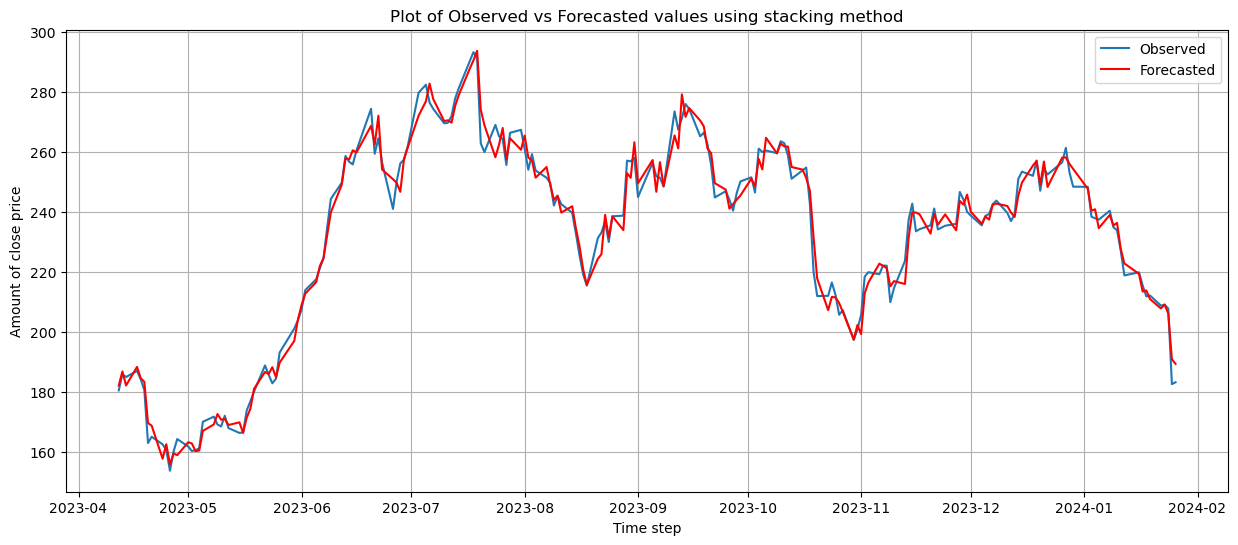

In [70]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(combined_stack['close'], label='Observed')
plt.plot(combined_stack[0], color='r', label='Forecasted')
plt.title('Plot of Observed vs Forecasted values using stacking method')
plt.ylabel('Amount of close price')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

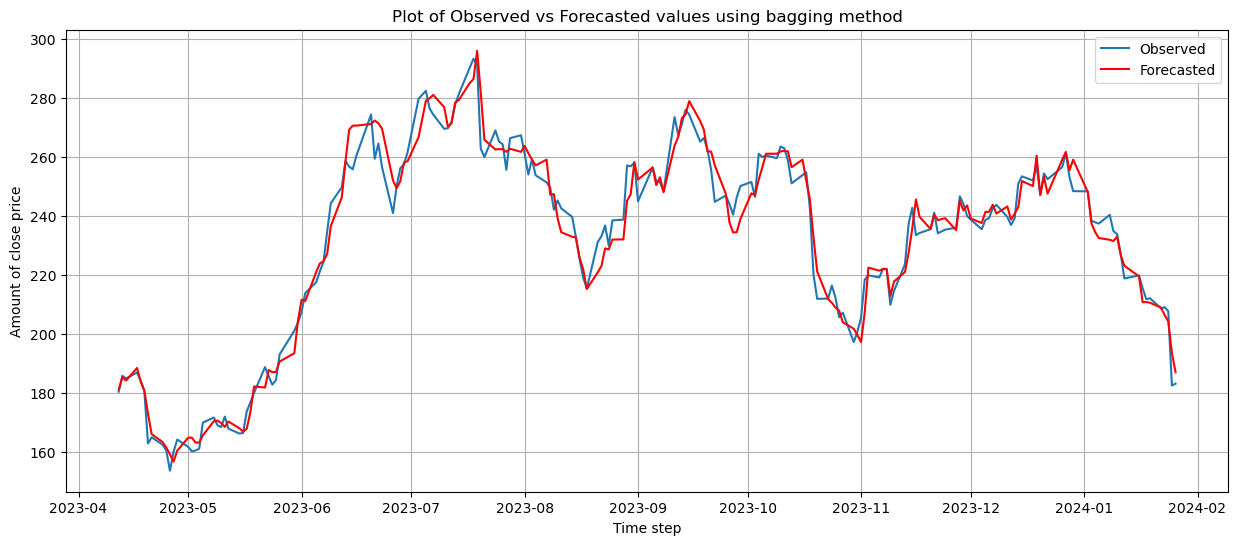

In [71]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(combined_bagg['close'], label='Observed')
plt.plot(combined_bagg[0], color='r', label='Forecasted')
plt.title('Plot of Observed vs Forecasted values using bagging method')
plt.ylabel('Amount of close price')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('TSLAresult.png')
plt.show()

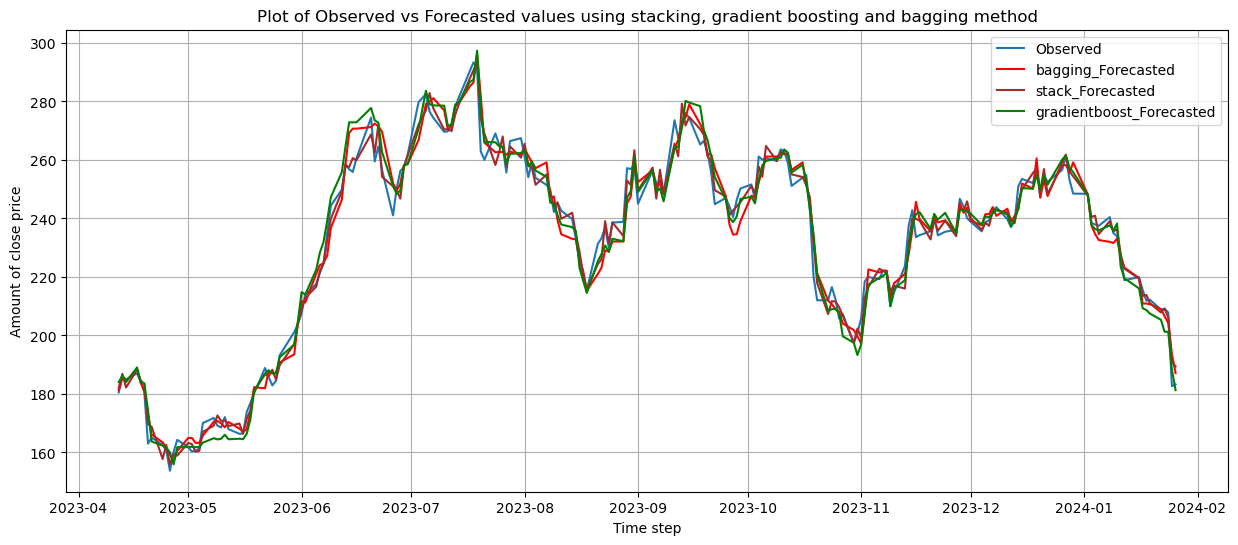

In [72]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(combined_bagg['close'], label='Observed')
plt.plot(combined_bagg[0], color='r', label='bagging_Forecasted')
plt.plot(combined_stack[0], color='brown', label='stack_Forecasted')
plt.plot(combined[0], color='green', label='gradientboost_Forecasted')
plt.title('Plot of Observed vs Forecasted values using stacking, gradient boosting and bagging method')
plt.ylabel('Amount of close price')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

In [73]:
from prettytable import PrettyTable
import joblib
import os
# Constructing the result summary table containing the scores for each model on  test dataset.

task1_result = PrettyTable()
task1_result.field_names = ["Regressor", "MAE on Test","MAPE on Test", "MinAE on Test", "MaxAE on Test", "MedAE on Test"]
task1_result.add_row(['RF Reg', 4.08, 0.02, 0.03, 15.50, 3.16])
task1_result.add_row(['XGboost', 4.47, 0.02, 0.03, 19.57, 3.60])
task1_result.add_row(['GradientBoost', 4.09, 0.02, 0.05, 19.18, 3.52])
task1_result.add_row(['Catboost', 5.12, 0.02, 0.16, 26.84, 3.79])
task1_result.add_row(['Bagging', 4.09, 0.02, 0.01, 18.90, 3.13])
task1_result.add_row(['Stacking', 3.03, 0.01, 0.03, 12.47, 2.53])

print('Result Summary for All Regressors :')
print(task1_result)

Result Summary for All Regressors :
+---------------+-------------+--------------+---------------+---------------+---------------+
|   Regressor   | MAE on Test | MAPE on Test | MinAE on Test | MaxAE on Test | MedAE on Test |
+---------------+-------------+--------------+---------------+---------------+---------------+
|     RF Reg    |     4.08    |     0.02     |      0.03     |      15.5     |      3.16     |
|    XGboost    |     4.47    |     0.02     |      0.03     |     19.57     |      3.6      |
| GradientBoost |     4.09    |     0.02     |      0.05     |     19.18     |      3.52     |
|    Catboost   |     5.12    |     0.02     |      0.16     |     26.84     |      3.79     |
|    Bagging    |     4.09    |     0.02     |      0.01     |      18.9     |      3.13     |
|    Stacking   |     3.03    |     0.01     |      0.03     |     12.47     |      2.53     |
+---------------+-------------+--------------+---------------+---------------+---------------+
